### Single Cancer Type Models for Centipede C April Readout

In [17]:
import numpy as np
import pandas as pd
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt

import featureio
import calzone
from pineapple.contrib.results.results_loader import load_results
from pineappleflow.core.loaders.contrib.experiment_loader import ExperimentLoader
import pineappleflow.core.experiment_context as experiment_context
import datetime
experiment_context.reset_context(0, "x", "x", datetime.datetime(2021, 3, 30,0,0))
print("s")

s


In [2]:
# split up M4 negs for train/test
def get_patient_ids_for_tc(training_class: str) -> List[int]:
    with featureio.FeatureIO() as ftio:
        dsids = ftio.get_datasets_for_training_class(training_class)
        metas = calzone.Calzone.get_dataset_metadata_with_ids(dsids)
        pids = [m.raw_sample_metadata['lims_patient']['id'] for m in metas]
        return pids

def get_patient_ids_for_training_class(training_class: str):
    with featureio.FeatureIO() as ftio:
        dsids = ftio.get_datasets_for_training_class(training_class)
        metas = calzone.Calzone.get_dataset_metadata_with_ids(dsids)
        pids = [m.raw_sample_metadata['lims_patient']['id'] for m in metas]
        #
        #return [sid for pid, sid in zip(pids, sids) if pid in patient_ids]
        return pids

def get_sids_for_training_class(training_class: str):
        dsids = ftio.get_datasets_for_training_class(training_class)
        metas = calzone.Calzone.get_dataset_metadata_with_ids(dsids)
        sids = [m.sample_metadata.id for m in metas]
        return sids
        

In [ ]:
# get patient ids that overlap between M4 neg and 96 plasmas 
M4_pids = get_patient_ids_for_tc('M4_NEGs_cpg_dense_v1')
neg96_pids = get_patient_ids_for_tc('colorectal_plasma_healthy_polyp_n') + get_patient_ids_for_tc('colorectal_plasma_healthy_polyp_y')
print("M4s:")
print(len(M4_pids))
print(len(set(M4_pids)))

print("96 negs:")
print(len(neg96_pids))
print(len(set(neg96_pids)))

print("Overlap PIDs:")
print(set(M4_pids).intersection(set(neg96_pids)))

In [25]:
# make M4 train and test sets that do not overlap 96plasma by pid
overlap_pids = set(M4_pids).intersection(set(neg96_pids))

with featureio.FeatureIO() as ftio:
    #get_datasets_for_training_class(self, training_class: 'str') -> 'List[str]'
    dsids = ftio.get_datasets_for_training_class("M4_NEGs_cpg_dense_v1")

pids = get_patient_ids_for_training_class("M4_NEGs_cpg_dense_v1")
non_overlapping_dsids = pd.Series([dsid for pid,dsid in zip(pids,dsids) if pid not in overlap_pids])
    
test_idxs = np.random.choice(range(len(non_overlapping_dsids)), int(len(non_overlapping_dsids)/3), replace=False)
M4_test_dsids = non_overlapping_dsids[test_idxs]

train_idxs = set(non_overlapping_dsids.index) - set(test_idxs)
M4_train_dsids = non_overlapping_dsids[list(train_idxs)]

Missed Redis cache for ttl_key TS-212506846, reading from BigQuery instead


In [ ]:
with featureio.FeatureIO() as ftio:
    #create_training_class(self, training_class_name: 'str', desc: 'str', datasets: 'Iterable[str]', 
    # tc_metadata_dict: 'Optional[dict]' = {}) -> 'str'
    metas_train = calzone.Calzone.get_dataset_metadata_with_ids(M4_train_dsids)
    ftio.create_training_class(training_class_name='M4_negs_cpg_dense_v1_train', 
                               desc='Subset of negs, not overlapping 96 healthy plasma set',
                               datasets=M4_train_dsids)
    
    metas_test = calzone.Calzone.get_dataset_metadata_with_ids(M4_test_dsids)
    ftio.create_training_class(training_class_name='M4_negs_cpg_dense_v1_test', 
                               desc='Subset of negs, not overlapping 96 healthy plasma set',
                               datasets=M4_test_dsids)

### Single model analyses
One model per tissue type, trained on tissue/plasma, tested on plasma only.


In [4]:
bucket = "freenome-user-data-bgould"
lung_path = "Multi_cancer/CentipedeC/Lung_tissue_trained_CHMFC"
liver_path = "Multi_cancer/CentipedeC/Liver_tissue_trained_CHMFC"
prostate_path = "Multi_cancer/CentipedeC/Prostate_tissue_trained_CHMFC"
ovarian_path = "Multi_cancer/CentipedeC/Ovarian_tissue_trained_CHMFC"
uterine_path = "Multi_cancer/CentipedeC/Uterine_tissue_trained_CHMFC"
pancreatic_path = "Multi_cancer/CentipedeC/Pancreatic_tissue_trained_CHMFC"
breast_path = "Multi_cancer/CentipedeC/Breast_tissue_trained_CHMFC"
esophageal_path = "Multi_cancer/CentipedeC/Esophageal_tissue_trained_CHMFC"
crc_path = "Multi_cancer/CentipedeC/CRC_tissue_trained_CHMFC"
paths = [lung_path,liver_path, prostate_path,ovarian_path,uterine_path,
         pancreatic_path,breast_path,esophageal_path,crc_path
        ]
cancer_types = ["Lung_Cancer","Liver_Cancer","Prostate_Cancer",
                "Ovarian_Cancer","Uterine_Cancer","Pancreatic_Cancer",
                "Breast_Cancer","Esophageal_Cancer","CRC_stageIV"
               ]
## ADD CRC
stage_dict = {"I":"I","II":"II","III":"III","IV":"IV",
             "IA":"I","IB":"I","IC":"I",
             "IIA":"II","IIB":"II","IIC":"II",
             "IIIA":"III","IIIB":"III","IIIC":"III",
             "IV":"IV","IVA":"IV","IVB":"IV","IVC":"IV",
             None:"Unknown", "Unavailable":"Unknown"}
stages = ["I","II","III","IV","Unknown"]

In [5]:
## plot of sensitivity for each cancer type 

def get_stage_sensitivity(bucket, path):

    metrics, fold, table_score = load_results(bucket, path)
    table_score['score1'] = table_score.score.apply(lambda x: x[1])
    df_negs = table_score[table_score["label"]==0]
    df_cancers = table_score[table_score["label"]==1]
    print(len(set(df_negs.sample_id)))
    print(len(set(df_cancers.sample_id)))

    df_negs_means = df_negs.groupby(["sample_id"]).agg({"score1":["mean"],"label":["max"]})
    df_negs_means.columns = ["mean_score","label"]

    df_cancers_means = df_cancers.groupby(["sample_id"]).agg({"score1":"mean","label":["max"]})
    df_cancers_means.columns = ["mean_score","label"]
    
    totPos = len(df_cancers_means)
    
    pct90_negs = np.percentile(df_negs_means.mean_score.values, 90)
    print(pct90_negs)
    df_cancers_means["call90"] = [1 if score >= pct90_negs else 0 for score in df_cancers_means["mean_score"]]
    TPs_90 = sum([a==1 and b==1 for a,b in zip(df_cancers_means["label"],df_cancers_means["call90"])])
    #FNs = sum([a==1 and b==0 for a,b in zip(df_cancers_means["label"],df_cancers_means["call"])])
    
    pct95_negs = np.percentile(df_negs_means.mean_score.values, 95)
    df_cancers_means["call95"] = [1 if score >= pct95_negs else 0 for score in df_cancers_means["mean_score"]]
    TPs_95 = sum([a==1 and b==1 for a,b in zip(df_cancers_means["label"],df_cancers_means["call95"])])
    
    pct99_negs = np.percentile(df_negs_means.mean_score.values, 99)
    df_cancers_means["call99"] = [1 if score >= pct99_negs else 0 for score in df_cancers_means["mean_score"]]
    TPs_99 = sum([a==1 and b==1 for a,b in zip(df_cancers_means["label"],df_cancers_means["call99"])])
    
    sid_to_stage = dict(zip(df_cancers['sample_id'],[m.raw_sample_metadata['lims_top_diagnosis']['stage'] for m in df_cancers["metadata"]]))
    df_cancers_means['stage'] = [stage_dict[sid_to_stage[s]] for s in df_cancers_means.index]
    
    sens_by_stage = []
    print(f"{cancer_type}: {set(df_cancers_means['stage'])}")
    for stage in stages:
        df_stage = df_cancers_means[df_cancers_means["stage"]==stage]
        TPs_stg = sum([a==1 and b==1 for a,b in zip(df_stage["label"],df_stage["call90"])])
        FNs_stg = sum([a==1 and b==0 for a,b in zip(df_stage["label"],df_stage["call90"])])
        n_pos_stg = TPs_stg + FNs_stg
        if n_pos_stg == 0:
            sens_by_stage.append((n_pos_stg, np.nan))
        else:
            sens_by_stage.append((n_pos_stg, TPs_stg/float(TPs_stg+FNs_stg)))
        
    return sens_by_stage, TPs_90, TPs_95, TPs_99, totPos
    

AttributeError: 'PipelineResult' object has no attribute 'fold_result_1'

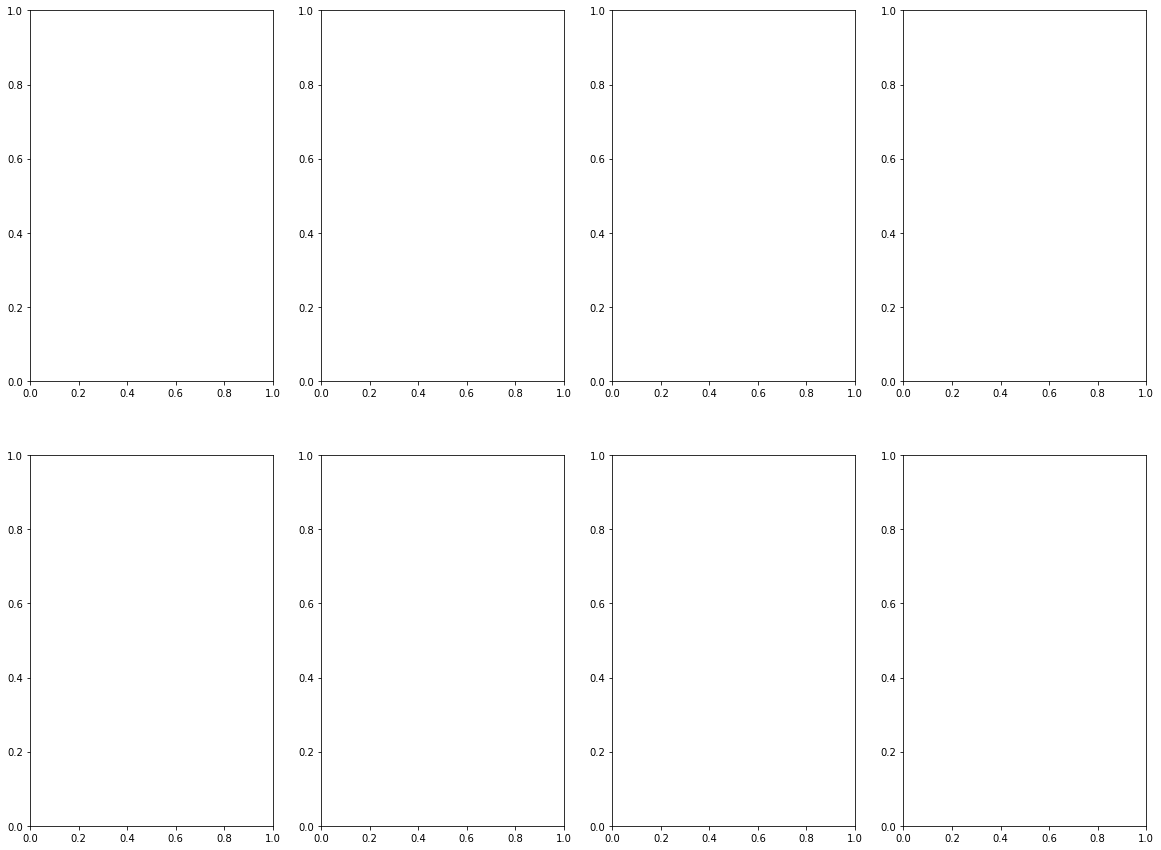

In [7]:
bar_data = []
fig, axs = plt.subplots(2,4, figsize=(20,15))
plot_coords = [(r,c) for r in range(2) for c in range(4)]
for i,(cancer_type,path) in enumerate(zip(cancer_types,paths),start=0):
    sens_by_stage, TPs_90, TPs_95, TPs_99, totPos = get_stage_sensitivity(bucket, path)
    bar_data.append((cancer_type,TPs_90, TPs_95, TPs_99, totPos))
    df = pd.DataFrame({"stage":[f"{stg} N={n}" for stg,n in zip(stages,[x[0] for x in sens_by_stage])],
                       "sensitivity":[x[1] for x in sens_by_stage],
                      "cancer_type": np.repeat(cancer_type, len(stages))}) 
    print(df)
    r, c = plot_coords[i]
    # plot each cancer type sens by stage
    axs[r][c].bar(df["stage"],df["sensitivity"],label=cancer_type)
    axs[r][c].set_xticklabels(labels=df['stage'],rotation=45)
    axs[r][c].set_ylim(0,1)
    for p in axs[r][c].patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        axs[r][c].text(x+width/2, 
            y+height/2, 
            '{:.2f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
    axs[r][c].set_title(f"{cancer_type}")
    axs[r][c].set_ylabel("Sensitivity @ 90spec")

plt.tight_layout()

Text(0.5, 1.0, 'Sensitivity by Cancer Type (multiple models)')

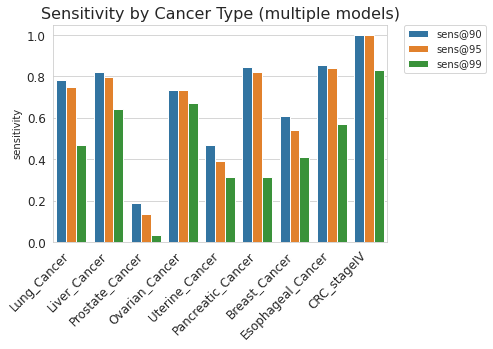

In [14]:
# plot across for each cancer types, total sens at 90 spec
df90 = pd.DataFrame({"cancer_type":[x[0] for x in bar_data],
                         "sensitivity":[x[1]/(x[4]) for x in bar_data],
                         "specificity": np.repeat("sens@90",len(bar_data))})

df95 = pd.DataFrame({"cancer_type":[x[0] for x in bar_data],
                         "sensitivity":[x[2]/(x[4]) for x in bar_data],
                         "specificity": np.repeat("sens@95",len(bar_data))})

df99 = pd.DataFrame({"cancer_type":[x[0] for x in bar_data],
                         "sensitivity":[x[3]/(x[4]) for x in bar_data],
                         "specificity": np.repeat("sens@99",len(bar_data))})

sns.set_style("whitegrid", {'axes.grid' : True})
ax = sns.barplot(x="cancer_type", y="sensitivity", hue="specificity", data=pd.concat([df90,df95,df99]))
plt.xticks(rotation=45,horizontalalignment='right',size=12)
plt.yticks(size=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("")
plt.title("Sensitivity by Cancer Type (multiple models)", size=16)

In [ ]:
from collections import Counter
## matrix of regions retained by each model
paths = [lung_path,liver_path, #prostate col meta missing for current feature
         #prostate_path,
         ovarian_path,uterine_path,
         pancreatic_path,breast_path,esophageal_path,#crc_path
        ]
cancer_types = ["Lung_Cancer","Liver_Cancer",#"Prostate_Cancer",
                "Ovarian_Cancer","Uterine_Cancer","Pancreatic_Cancer",
                "Breast_Cancer","Esophageal_Cancer",#"CRC_stageIV"
               ]
cpg_cutoffs_by_tissue = {}
reg_retained_by_tissue = {}
for i,path in enumerate(paths):
    print(path)
    loader = ExperimentLoader(bucket, path)
    folds = loader.fold_names()
    cpg_cutoffs =[]
    reg_retained = []
    for fold_name in folds:
        fold = loader.fold(fold_name)
        choose_reg =fold._pipeline_result.pipeline.transformer_chains['mint-chmcfc-multicancer-dsc/v1'][1]
        poisson = fold._pipeline_result.pipeline.transformer_chains['mint-chmcfc-multicancer-dsc/v1'][2]
        col_meta = fold.pre_transformer_fold_holder.test['mint-chmcfc-multicancer-dsc/v1'].column_metadata
        #matrix = fold._pipeline_result.pipeline.transformer_chains['HMFC_consecutive_regions_all/v1'][1].transform(data)
        reg_retained_fold = col_meta[choose_reg.features_to_keep][poisson.features_to_keep]
        reg_retained.append(reg_retained_fold)
        #print(Counter(poisson.features_to_keep)) #some true, some false
        cpg_cutoffs.append(choose_reg.best_feature_per_region)
    cpg_cutoffs = pd.DataFrame(cpg_cutoffs).mean(axis=0)
    cpg_cutoffs_by_tissue[cancer_types[i]]=cpg_cutoffs
    reg_retained_str = set([f'{r["start"]}{r["name"]}' for sublist in reg_retained for r in sublist])#regions used in at least one fold
    reg_retained_by_tissue[cancer_types[i]]=reg_retained_str
    
#plot matrix of region overlaps by tissue
df = pd.DataFrame(columns=cancer_types, index=cancer_types)
df_pct = pd.DataFrame(columns=cancer_types, index=cancer_types)
for i in cancer_types:
    for j in cancer_types:
        #print(i)
        A = len(reg_retained_by_tissue[i])
        #print(j)
        B = float(len(reg_retained_by_tissue[j]))
        overlap = len(reg_retained_by_tissue[i].intersection(reg_retained_by_tissue[j]))
        #print(overlap/((A+B)/2))
        df.loc[i,j] = overlap
        df_pct.loc[i,j] = overlap/((A+B)/2)

print(df)
print(df_pct)
plt.figure(figsize=(10,10))
df = df.fillna(0)
#mask = np.triu(df)
df_pct = df_pct.fillna(0)
mask = np.tril(np.ones(df.shape)).astype(np.bool)
ax = sns.heatmap(data=df_pct.where(mask), annot=df.where(mask), fmt='g')
plt.title("number of overlapping regions")
plt.figure(figsize=(10,10))
ax = sns.heatmap(data=df_pct.where(mask), annot=df_pct.where(mask), fmt='.2f')
plt.title("proportion of overlapping regions")

Multi_cancer/CentipedeC/Lung_tissue_trained_CHMFC


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['sta

Multi_cancer/CentipedeC/Liver_tissue_trained_CHMFC


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['sta

Multi_cancer/CentipedeC/Ovarian_tissue_trained_CHMFC


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['sta

Multi_cancer/CentipedeC/Uterine_tissue_trained_CHMFC


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['sta

Multi_cancer/CentipedeC/Pancreatic_tissue_trained_CHMFC


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['sta

In [222]:
# plot scores by type and stage
paths = [lung_path,liver_path,
         prostate_path,
         ovarian_path,uterine_path,
         pancreatic_path,breast_path,esophageal_path,crc_path
        ]
cancer_types = ["Lung_Cancer","Liver_Cancer","Prostate_Cancer",
                "Ovarian_Cancer","Uterine_Cancer","Pancreatic_Cancer",
                "Breast_Cancer","Esophageal_Cancer","CRC_stageIV"
               ]
dfs=[]
for i,(path,cancer_type) in enumerate(zip(paths,cancer_types)):
    metrics, fold, table_score = load_results(bucket, path)
    table_score['score1'] = table_score.score.apply(lambda x: x[1])
    df_negs = table_score[table_score["label"]==0]
    df_cancers = table_score[table_score["label"]==1]
    print(len(set(df_negs.sample_id)))
    print(len(set(df_cancers.sample_id)))

    df_negs_means = df_negs.groupby(["sample_id"]).agg({"score1":["mean"],"label":["max"]})
    df_negs_means.columns = ["mean_score","label"]
    #df_negs_means["log_score"] = np.log(df_negs_means["mean_score"])
    #print(df_negs_means.head())

    df_cancers_means = df_cancers.groupby(["sample_id"]).agg({"score1":"mean","label":["max"]})
    df_cancers_means.columns = ["mean_score","label"]
    #df_cancers_means["log_score"] = np.log(df_cancers_means["mean_score"])
    
    #df_mean_scores = pd.concat([df_negs_means,df_cancers_means])
    #pct90_negs = np.percentile(df_negs_means.mean_score.values, 90)
    #print(pct90_negs)
    #df_cancers_means["call"] = [1 if score >= pct90_negs else 0 for score in df_cancers_means["mean_score"]]
    
    sid_to_stage = dict(zip(df_cancers['sample_id'],[m.raw_sample_metadata['lims_top_diagnosis']['stage'] for m in df_cancers["metadata"]]))
    df_cancers_means['stage'] = [stage_dict[sid_to_stage[s]] for s in df_cancers_means.index]
    df_cancers_means['cancer_type'] = cancer_type
    df_negs_means['cancer_type'] = cancer_type
    df_negs_means['stage'] = 'healthy'
    if cancer_type=="CRC_stageIV":
        df_cancers_means['stage'] = "IV"
    
    df_type = pd.concat([df_cancers_means,df_negs_means])
    dfs.append(df_type)
    


199
64
199
39
199
59
199
49
199
51
199
83
199
46
199
56
207
24


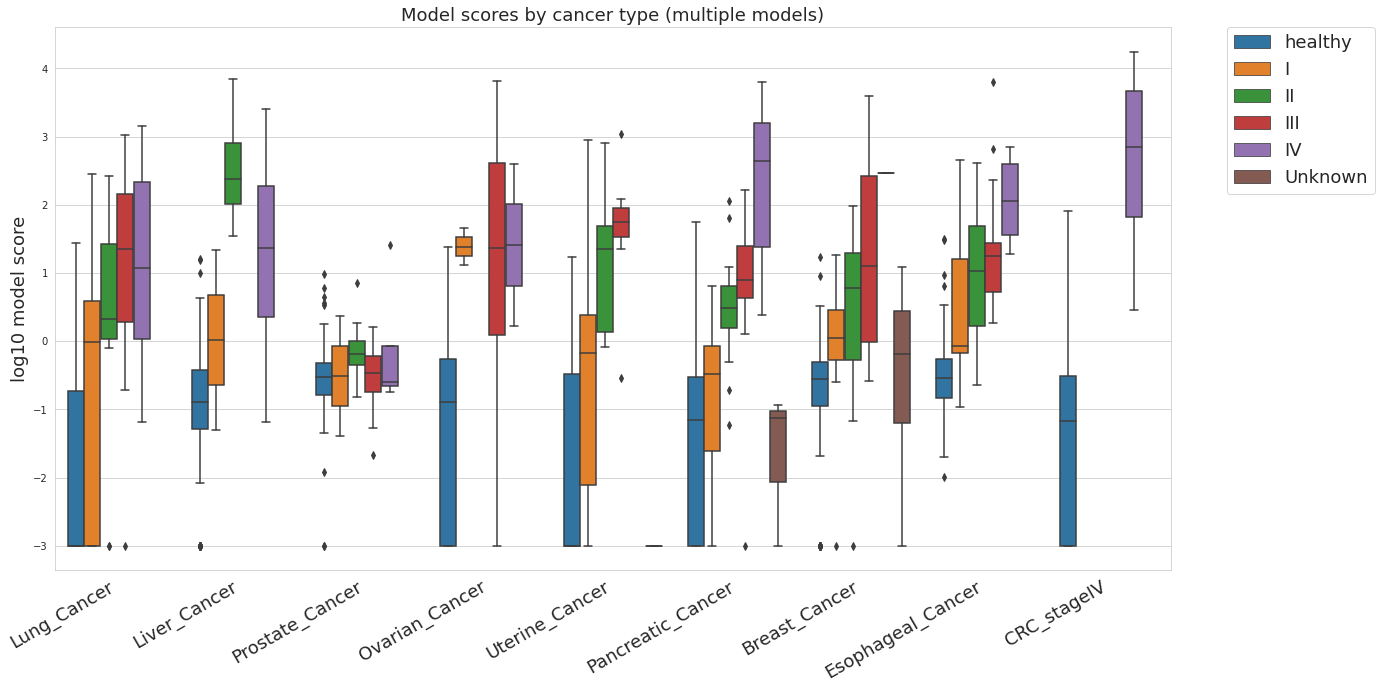

In [224]:
df_all = pd.concat(dfs)    
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="cancer_type",y=np.log10(df_all["mean_score"]+0.001),data=df_all,hue="stage",
                hue_order=["healthy","I","II","III","IV","Unknown"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha="right",size=18)
#ax.set_yticklabels(ax.get_yticklabels(),size=18)
plt.title("Model scores by cancer type (multiple models)", size=18)
ax.set_ylabel("log10 model score", size=18)
ax.set_xlabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=18)

In [28]:
# generate a table of samples and scores and folds for JSJ's bootstrap analysis
#ModelScore,SampleID,DatasetID,CancerType,Label,Stage,FoldNumber

paths = [lung_path,liver_path,
         prostate_path,
         ovarian_path,uterine_path,
         pancreatic_path,breast_path,esophageal_path,crc_path
        ]
cancer_types = ["Lung_Cancer","Liver_Cancer","Prostate_Cancer",
                "Ovarian_Cancer","Uterine_Cancer","Pancreatic_Cancer",
                "Breast_Cancer","Esophageal_Cancer","CRC_stageIV"
               ]
dfs=[]
for i,(path,cancer_type) in enumerate(zip(paths,cancer_types)):
    loader = ExperimentLoader(bucket, path)
    fold = loader.fold(loader.fold_names()[0])
    test_data = fold.pre_transformer_fold_holder.test['HMFC_consecutive_regions_all/v1']
    sid_to_dsid = dict(zip(test_data.sample_ids,test_data.dataset_ids))
    print(list(sid_to_dsid.items())[0:5])
    train_data = fold.pre_transformer_fold_holder.train['HMFC_consecutive_regions_all/v1']
    sid_to_dsid.update(dict(zip(train_data.sample_ids,train_data.dataset_ids)))
    
    metrics, fold, df_table_score = load_results(bucket, path)
    #print(df_table_score.head())
    df_table_score['score1'] = df_table_score.score.apply(lambda x: x[1])
    #print(df_table_score["metadata"][0])
    sid_to_stage = dict(zip(df_table_score['sample_id'],[m.raw_sample_metadata['lims_top_diagnosis']['stage'] for m in df_table_score["metadata"]]))
    sid_to_cancer_type = dict(zip(df_table_score['sample_id'],[m.raw_sample_metadata['lims_top_diagnosis']['cancer_type'] for m in df_table_score["metadata"]]))
    
    df_table_score['stage'] = [stage_dict[sid_to_stage[s]] for s in df_table_score['sample_id']]
    df_table_score['dataset_id'] = [sid_to_dsid[s] for s in df_table_score['sample_id']]
    df_table_score = df_table_score.drop(["metadata","score","prediction"], axis=1)
    dfs.append(df_table_score)
    
    
df_all = pd.concat(dfs)
print(df_all.head())
print(df_all.shape)
print(Counter(df_all["stage"]))

with open("./single_cancer_type_models_sample_scores.csv","w") as fout:
    df_all.to_csv(fout, index=False)

EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples


KeyError: 'HMFC_consecutive_regions_all/v1'

In [ ]:
paths = [lung_path,liver_path,
         prostate_path,
         ovarian_path,uterine_path,
         pancreatic_path,breast_path,esophageal_path,crc_path
        ]
cancer_types = ["Lung_Cancer","Liver_Cancer","Prostate_Cancer",
                "Ovarian_Cancer","Uterine_Cancer","Pancreatic_Cancer",
                "Breast_Cancer","Esophageal_Cancer","CRC_stageIV"
               ]
reg_retained_by_cancer = {}
for i,(path,cancer_type) in enumerate(zip(paths,cancer_types)):
    reg_retained = []
    loader = ExperimentLoader(bucket, path)
    for fold in loader.fold_names():
        fold = loader.fold(fold)
        matrix = fold.pre_transformer_fold_holder.test['mint-chmcfc-multicancer-dsc/v1']
        choosereg = fold._pipeline_result.pipeline.transformer_chains['mint-chmcfc-multicancer-dsc/v1'][1]
        poisson = fold._pipeline_result.pipeline.transformer_chains['mint-chmcfc-multicancer-dsc/v1'][2]
        col_meta = matrix.column_metadata[choosereg.features_to_keep][poisson.features_to_keep]
        col_meta_str = [f'{d["start"]}{d["end"]}' for d in col_meta]
        reg_retained.extend(col_meta_str)

    reg_retained_by_cancer[cancer_type] = set(reg_retained)

df_map = pd.DataFrame(columns=cancer_types,index=cancer_types)
df_pct = pd.DataFrame(columns=cancer_types,index=cancer_types)
for i in cancer_types:
    for j in cancer_types:
        intersec = reg_retained_by_cancer[i].intersection(reg_retained_by_cancer[j])
        union = reg_retained_by_cancer[i].union(reg_retained_by_cancer[j])
        df_map.loc[i,j] = len(intersec)
        df_pct.loc[i,j] = len(intersec)/float(len(union))
print(df_map)
print(df_pct)
df_pct = df_pct.fillna(0)
plt.figure()
sns.heatmap(df_pct, annot=df_map, fmt='d')
plt.figure()
sns.heatmap(df_pct, annot=df_pct, fmt='.2g')

EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['sta

<AxesSubplot:>

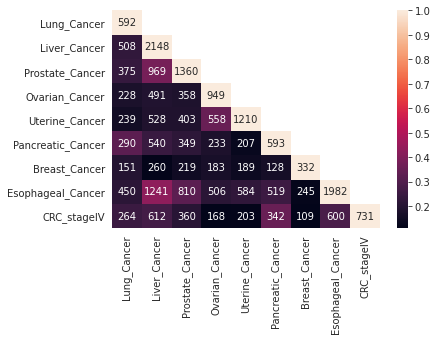

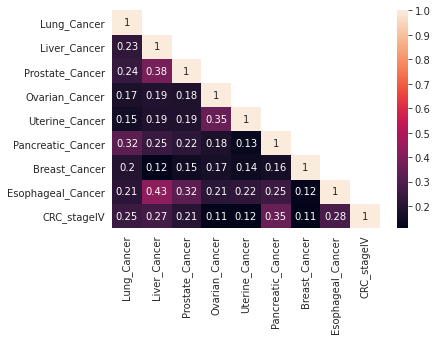

In [228]:
# replot lower triangle
df_pct_lt = df_pct.where(np.tril(np.ones(df_map.shape, dtype=bool)))
plt.figure()
sns.heatmap(df_pct_lt, annot=df_map, fmt='d')
plt.title("Overlap between cancer region markers", size=16)
plt.figure()
sns.heatmap(df_pct_lt, annot=df_pct, fmt='.2g')

In [208]:
# is there tissue plasma overlap by PID for CRC?

pid_plasma = get_patient_ids_for_tc('colorectal_plasma_cancer_stage_IV_chemo_y') + get_patient_ids_for_tc('colorectal_plasma_cancer_stage_IV_chemo_n')


pid_tissue = get_patient_ids_for_tc('colorectal_tissue_cancer_stage_IV_chemo_n') + get_patient_ids_for_tc('colorectal_tissue_cancer_stage_IV_chemo_y')

overlap = set(pid_plasma).intersection(set(pid_tissue))

print(len(pid_plasma))
print(len(pid_tissue))
print(len(overlap))

24
24
24


In [18]:
# qc fails by tissue type
with open("./centipede_c_qc_calls.csv","r") as fin:
    df_qc = pd.read_csv(fin)

df_qc.head()

,sample_dataset_id,batch_id,manual_passed,batch_decision,notes
0,SD-0001E856,980,True,True,Batch and sample passed. (james.chuang@freenom...
1,SD-0001E84C,980,True,True,Batch and sample passed. (james.chuang@freenom...
2,SD-0001E80C,980,False,True,"Batch passed, but sample failed: Mean target c..."
3,SD-0001E818,980,True,True,Batch and sample passed. (james.chuang@freenom...
4,SD-0001E80B,980,False,True,"Batch passed, but sample failed: Mean target c..."


In [25]:
metas = calzone.Calzone.get_dataset_metadata_with_ids(df_qc["sample_dataset_id"])
#print(metas[0])
df_qc["cancer_type"] = [m.raw_sample_metadata['lims_top_diagnosis']['cancer_type'] for m in metas]
df_qc["sample id"] = [m.raw_dataset_metadata["dataset"]["sample_id"] for m in metas]


df_qc_fail = df_qc[df_qc["manual_passed"]==False]
Counter(df_qc_fail["cancer_type"])
print(df_qc_fail[df_qc_fail["cancer_type"]=="Pancreatic Cancer"])
#ovarian
# 60 lab processed
# james - 2 fail qc
# hayley - 4 fail qc
# 58 in full training class
# 8 overlap between tissue tc and plasma tc
# 1 fails allele freq check

#pancreatic


Missed Redis cache for ttl_key TS-212527538, reading from BigQuery instead


    sample_dataset_id  batch_id  manual_passed  batch_decision  \
367       SD-0001EB64      1024          False            True   
416       SD-0001EAD0      1024          False            True   
433       SD-0001EA9E      1024          False            True   
572       SD-0001F159      1036          False            True   

                                                 notes        cancer_type  \
367  Batch passed, but sample failed: Reported sex ...  Pancreatic Cancer   
416  Batch passed, but sample failed: Mean target c...  Pancreatic Cancer   
433  Batch passed, but sample failed: Mean target c...  Pancreatic Cancer   
572  Batch passed, but sample failed: Mean target c...  Pancreatic Cancer   

     sample id  
367     104025  
416      20056  
433     104162  
572     104716  


In [45]:

from pineappleflow.core.gcloud.gcs_helpers import download_file_from_gcs_path
# download analysis hooks results
paths = [lung_path,liver_path,
         prostate_path,
         ovarian_path,uterine_path,
         pancreatic_path,breast_path,esophageal_path,crc_path
        ]
cancer_types = ["Lung_Cancer","Liver_Cancer",
                "Prostate_Cancer",
                "Ovarian_Cancer","Uterine_Cancer","Pancreatic_Cancer",
                "Breast_Cancer","Esophageal_Cancer","CRC_stageIV"
               ]
reg_retained_by_cancer = {}
for i,(path,cancer_type) in enumerate(zip(paths,cancer_types)):
    #help(download_file_from_gcs_path)
    !gsutil cp gs://{bucket}/{path}/analysis_hooks/confounder_ancova_full_results_table.tsv ./{cancer_type}_confounder_ancova.tsv



Copying gs://freenome-user-data-bgould/Multi_cancer/CentipedeC/Lung_tissue_trained_CHMFC/analysis_hooks/confounder_ancova_full_results_table.tsv...
/ [1 files][  1.2 KiB/  1.2 KiB]                                                
Operation completed over 1 objects/1.2 KiB.                                      
Copying gs://freenome-user-data-bgould/Multi_cancer/CentipedeC/Liver_tissue_trained_CHMFC/analysis_hooks/confounder_ancova_full_results_table.tsv...
/ [1 files][  1.3 KiB/  1.3 KiB]                                                
Operation completed over 1 objects/1.3 KiB.                                      
Copying gs://freenome-user-data-bgould/Multi_cancer/CentipedeC/Prostate_tissue_trained_CHMFC/analysis_hooks/confounder_ancova_full_results_table.tsv...
/ [1 files][  1.3 KiB/  1.3 KiB]                                                
Operation completed over 1 objects/1.3 KiB.                                      
Copying gs://freenome-user-data-bgould/Multi_cancer/CentipedeC

In [59]:
dfs = []
for cancer_type in cancer_types:
    with open(f'./{cancer_type}_confounder_ancova.tsv','r') as fin: #moved these files
        df_type = pd.read_csv(fin, sep="\t").sort_values("PR(>F)")
        #ind = list(df.iloc[:,0]).index("y")
        #df_type = df.iloc[0:ind,[0,5]]
        df_type = df_type[df_type["PR(>F)"]<=0.050]
        df_type["cancer_type"] = cancer_type
        print(df_type.head(20))
        dfs.append(df_type)

df_all = pd.concat(dfs)
df_all = df_all.iloc[:,[0,5,6]]
df_all.columns = ["Confounder","p-value","cancer_type"]
print(df_all.shape)
with open('./CentipedeC_multiple_models_confounders.tsv','w') as fout:
    df_all.to_csv(fout, index=False)

                                          Unnamed: 0   df    sum_sq   mean_sq  \
6  scrubbed_flowcells_HVNC7DSXY_HVNYNDSXY_HVTC3DS...  1.0  2.164814  2.164814   
5  scrubbed_flowcells_HVN7LDSXY_HVN7NDSXY_HVTCNDS...  1.0  1.281715  1.281715   
3  scrubbed_flowcells_HVMKLDSXY_HVMLCDSXY_HVMLLDS...  1.0  0.301355  0.301355   
2  scrubbed_flowcells_HVHCCDSXY_HVMLJDSXY_HVMMCDS...  1.0  0.205229  0.205229   
4  scrubbed_flowcells_HVMLHDSXY_HVN5WDSXY_HVNLFDS...  1.0  0.185751  0.185751   
0                           sample_metadata_sex_Male  1.0  0.171013  0.171013   
1  scrubbed_flowcells_HVGYCDSXY_HVKYNDSXY_HVMM5DS...  1.0  0.105274  0.105274   

            F        PR(>F)  cancer_type  
6  140.546713  4.261888e-26  Lung_Cancer  
5   83.213099  2.333120e-17  Lung_Cancer  
3   19.564928  1.443199e-05  Lung_Cancer  
2   13.324134  3.180487e-04  Lung_Cancer  
4   12.059552  6.055180e-04  Lung_Cancer  
0   11.102688  9.903165e-04  Lung_Cancer  
1    6.834713  9.474397e-03  Lung_Cancer  
       

In [84]:
# top 50 regions per cancer type
paths = [lung_path,
    liver_path,
         prostate_path,
         ovarian_path,uterine_path,
         pancreatic_path,breast_path,esophageal_path,crc_path
        ]
cancer_types = ["Lung_Cancer","Liver_Cancer",
                "Prostate_Cancer",
                "Ovarian_Cancer","Uterine_Cancer","Pancreatic_Cancer",
                "Breast_Cancer","Esophageal_Cancer","CRC_stageIV"
               ]
top_reg_by_type = {}
for i,(path,cancer_type) in enumerate(zip(paths,cancer_types)):
    fold_effect_sizes = []
    loader = ExperimentLoader(bucket, path)
    for fold in loader.fold_names():
        fold = loader.fold(fold)
        col_meta = fold.pre_transformer_fold_holder.test['mint-chmcfc-multicancer-dsc/v1'].column_metadata
        choosereg = fold._pipeline_result.pipeline.transformer_chains['mint-chmcfc-multicancer-dsc/v1'][1]
        #poisson = fold._pipeline_result.pipeline.transformer_chains['mint-chmcfc-multicancer-dsc/v1'][2]
        fold_effect_sizes.append(choosereg.pessimistic_effect_size)
        assert len(choosereg.pessimistic_effect_size==len(col_meta))
    
    genes = [d["name"] for d in col_meta]
    coords = [f'{d["seqname"]}:{d["start"]}-{d["end"]}' for d in col_meta]
    mean_effect_sizes = pd.DataFrame(fold_effect_sizes).mean(axis=0)
    df = pd.DataFrame({"position":coords,"name":genes,'effect_size':mean_effect_sizes}).sort_values('effect_size',ascending=False)
    print(df.head())
    with open(f'./CHMFC/effect_sizes/{cancer_type}_effect_sizes.csv','w') as fout:
        df.iloc[0:50,:].to_csv(fout, index=False)

    top_reg_by_type[cancer_type] = set(df.iloc[0:50,:]["position"])
    
df_map = pd.DataFrame(columns=cancer_types,index=cancer_types)
df_pct = pd.DataFrame(columns=cancer_types,index=cancer_types)
for i in cancer_types:
    for j in cancer_types:
        intersec = top_reg_by_type[i].intersection(top_reg_by_type[j])
        union = top_reg_by_type[i].union(top_reg_by_type[j])
        df_map.loc[i,j] = len(intersec)
        df_pct.loc[i,j] = len(intersec)/float(len(union))
print(df_map)
print(df_pct)
#plotting next cell

EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['sta

                      position     name  effect_size
4164    chr2:43223967-43225634  ZFP36L2  5429.455772
358     chr1:92484367-92485990     GFI1  4234.951043
5459  chr3:143118923-143121172    CHST2  2533.362288
6972    chr7:27150655-27151587    HOXA6  2420.331268
6841  chr6:152301655-152302345    SYNE1  2104.218040


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['sta

                      position   name  effect_size
663   chr1:226223434-226224337  MIXL1  7820.573036
358     chr1:92484367-92485990   GFI1  6603.830792
5459  chr3:143118923-143121172  CHST2  4163.966240
762    chr10:17228172-17229898    VIM  3624.259407
732      chr10:3068327-3069261   PFKP  3579.898674


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['sta

                      position     name   effect_size
7726    chr9:27528978-27529887    MOB3B  35702.322100
5563  chr3:187737727-187739106     BCL6  22203.513088
4164    chr2:43223967-43225634  ZFP36L2  19704.616939
4543  chr2:190180299-190181293  C2orf88  17122.414155
7078    chr7:76302614-76303942    HSPB1  14772.612872


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['sta

                      position     name   effect_size
229     chr1:46302590-46304060   LRRC41  17824.182486
6738  chr6:106511524-106513135   CRYBG1  14710.425017
5563  chr3:187737727-187739106     BCL6  13888.192220
3099   chr17:44014457-44015264  TMEM101  10310.727694
228     chr1:46301753-46302464   LRRC41   6886.166635


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['sta

                      position      name   effect_size
3099   chr17:44014457-44015264   TMEM101  10973.057264
229     chr1:46302590-46304060    LRRC41   9650.134098
6284  chr5:143402157-143405740     NR3C1   6713.567271
5248    chr3:36992402-36993909  EPM2AIP1   4773.450522
5514  chr3:169764550-169765264      TERC   4609.643206


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['sta

                      position       name  effect_size
1980   chr13:32031121-32031706        FRY  7421.979815
2746   chr16:23835462-23837382      PRKCB  6181.379923
583   chr1:182614756-182615290  LINC01686  4925.126346
7179  chr7:114922520-114923332      MDFIC  3753.605685
7440    chr8:38467853-38468775      FGFR1  3572.921076


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['sta

                      position      name   effect_size
5459  chr3:143118923-143121172     CHST2  20308.104419
3066   chr17:39209733-39210193     RPL19  19476.453008
4832   chr20:38646150-38646491  ARHGAP40  12477.408205
690   chr1:231039316-231040287    FAM89A  11302.514223
6955    chr7:23468438-23470152   IGF2BP3  11023.992686


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['sta

                      position          name  effect_size
1614   chr12:24561430-24562526          SOX5  7984.878239
7945  chr9:130042000-130043635         FNBP1  6717.246241
7261  chr7:149873235-149874341  ATP6V0E2-AS1  5701.612384
1615   chr12:24562778-24563470          SOX5  5623.105700
5857  chr4:140373210-140374120      SCOC-AS1  5434.767230


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 231 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 231 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 231 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 231 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 231 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 231 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 231 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 231 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['sta

                      position     name   effect_size
5459  chr3:143118923-143121172    CHST2  31065.810163
4141    chr2:29114827-29116226    CLIP4  30450.764681
4146    chr2:31137191-31138955  GALNT14  23317.995062
5475  chr3:151085209-151087108   MED12L  19130.688716
6663    chr6:72620907-72623381    KCNQ5  15645.175532
                  Lung_Cancer Liver_Cancer Prostate_Cancer Ovarian_Cancer  \
Lung_Cancer                50           13               6              7   
Liver_Cancer               13           50               1              2   
Prostate_Cancer             6            1              50              8   
Ovarian_Cancer              7            2               8             50   
Uterine_Cancer             14            4               6             24   
Pancreatic_Cancer          15            9               1              3   
Breast_Cancer              15            9               9              8   
Esophageal_Cancer          11            8               5  

AttributeError: module 'numpy' has no attribute 'zeroes'

Text(0.5, 1.0, 'Overlap among the top 50 regions for each cancer type')

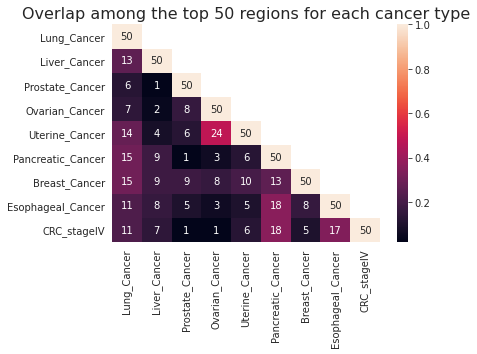

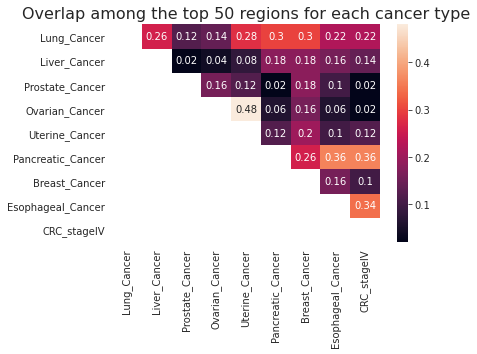

In [92]:
df_pct = df_pct.fillna(0)
df_pct_lt = df_pct.where(np.tril(np.ones(df_map.shape, dtype=bool)))
plt.figure()
sns.heatmap(df_pct_lt, annot=df_map, fmt='.2g')
plt.title('Overlap among the top 50 regions for each cancer type', size=16)
#plt.figure()
#sns.heatmap(df_pct, annot=df_pct, fmt='g',mask=mask)
#plt.title('Overlap among the top 50 regions for each cancer type', size=16)

## TOO Classification

In [2]:
from pineapple.contrib.results.results_loader import load_results
from pineapple.contrib.components.data_factories.matrix_factory import MatrixFactory as mf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression

from collections import Counter

EXPERIMENT LOADER: Redirecting to use Loaders in Pineappleflow. Please import loaders from 'from pineappleflow.core.loaders.contrib.experiment_loader' instead.


In [6]:
# isolate samples called as true positive at 90% specificity
paths = [lung_path,
    liver_path,
         prostate_path,
         ovarian_path,uterine_path,
         pancreatic_path,breast_path,esophageal_path,crc_path
        ]
cancer_types = ["Lung_Cancer","Liver_Cancer",
                "Prostate_Cancer",
                "Ovarian_Cancer","Uterine_Cancer","Pancreatic_Cancer",
                "Breast_Cancer","Esophageal_Cancer","CRC_stageIV"
               ]

pos_sids = []
dsid_to_cancer_type = {}
sid_to_dsid = {}
for i,(path,cancer_type) in enumerate(zip(paths,cancer_types)):
    # get dsids
    loader = ExperimentLoader(bucket, path)
    folds = loader.fold_names()
    fold = loader.fold(folds[0])
    mat_test = fold.pre_transformer_fold_holder.test['mint-chmcfc-multicancer-dsc/v1']
    sid_to_dsid.update(dict(zip(mat_test.sample_ids,mat_test.dataset_ids)))
    mat_train = fold.pre_transformer_fold_holder.train['mint-chmcfc-multicancer-dsc/v1']
    sid_to_dsid.update(dict(zip(mat_train.sample_ids,mat_train.dataset_ids)))
    
    # call samples at 90% spec threshold
    _, _, table_score = load_results(bucket, path)
    table_score['score1'] = table_score.score.apply(lambda x: x[1])
    df_negs = table_score[table_score["label"]==0]
    df_cancers = table_score[table_score["label"]==1]
    
    df_negs_means = df_negs.groupby(["sample_id"]).agg({"score1":["mean"],"label":["max"]})
    df_negs_means.columns = ["mean_score","label"]

    df_cancers_means = df_cancers.groupby(["sample_id"]).agg({"score1":"mean","label":["max"]})
    df_cancers_means.columns = ["mean_score","label"]

    pct90_negs = np.percentile(df_negs_means.mean_score.values, 90)
    df_cancers_means["call90"] = [1 if score >= pct90_negs else 0 for score in df_cancers_means["mean_score"]]
    df_negs_means["call90"] = [1 if score >= pct90_negs else 0 for score in df_negs_means["mean_score"]]
    
    # record positive labeled dsids
    pos_sids.extend(list(df_cancers_means[df_cancers_means["call90"]==1].index))
    pos_sids.extend(list(df_negs_means[df_negs_means["call90"]==1].index))
    
    # record cancer types
    dsids_cancer = [sid_to_dsid[sid] for sid in list(df_cancers_means.index)]
    dsid_to_cancer_type.update(dict(zip(dsids_cancer, np.repeat(cancer_type, len(dsids_cancer)))))
    dsids_negs = [sid_to_dsid[sid] for sid in list(df_negs_means.index)]
    dsid_to_cancer_type.update(dict(zip(dsids_negs, np.repeat("Healthy",len(dsids_negs)))))
    print(f'{cancer_type} complete')
    

EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples


Lung_Cancer complete


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples


Liver_Cancer complete


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples


Prostate_Cancer complete


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples


Ovarian_Cancer complete


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 200 samples


Uterine_Cancer complete


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 202 samples


Pancreatic_Cancer complete


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples


Breast_Cancer complete


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 199 samples


Esophageal_Cancer complete


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['stage']" in 231 samples


CRC_stageIV complete


In [7]:
# get avg. CpG thresholds learned by each model and subset test data
## NOTE: Switched to a new branch 'thomas/pineappleflow_compatibility'

cutoffs_list = []
data_dfs = []
for i,(path,cancer_type) in enumerate(zip(paths,cancer_types)):
    loader = ExperimentLoader(bucket, path)
    folds = loader.fold_names()
    cpg_cutoffs =[]
    for fold_name in folds:
        fold = loader.fold(fold_name)
        choose_reg =fold._pipeline_result.pipeline.transformer_chains['mint-chmcfc-multicancer-dsc/v1'][1]
        cpg_cutoffs.append(choose_reg.best_feature_per_region)
    cpg_cutoffs = pd.DataFrame(cpg_cutoffs).mean(axis=0)
    cutoffs_list.append(cpg_cutoffs)
    
    # filter data to type-specific cpg cutoffs
    dsids_cancer = [dsid for dsid,ct in dsid_to_cancer_type.items() if ct==cancer_type]
    mat = mf.create_from_dataset_ids(dsids_cancer,
                                    feature_str='mint-chmcfc-multicancer-dsc/v1',
                                    dataset_labels=np.repeat(1,len(dsids_cancer)))
    hmf_rates = mat.x[...,0]/mat.x[...,1]
    data = []
    for i , cutoff in enumerate(cpg_cutoffs):
        data.append(hmf_rates[:,i,int(np.round(cutoff,0))])
    df_data = pd.DataFrame(data, columns=mat.sample_ids).T ##sids x regions
    data_dfs.append(df_data)


EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
Missed Redis cache for 28 datasets with timestamp 2021-03-30 00:00:00, reading from BigQuery instead
EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold

In [9]:
# combine and filter test data
df_cancer_data = pd.concat(data_dfs)
print(df_cancer_data.shape)
samples_to_keep = [sid in pos_sids for sid in df_cancer_data.index]
df_cancer_data = df_cancer_data[samples_to_keep]
  
dsids_healthy = [dsid for dsid,ct in dsid_to_cancer_type.items() if ct=="Healthy"]
mat = mf.create_from_dataset_ids(dsids_healthy,
                                    feature_str='mint-chmcfc-multicancer-dsc/v1',
                                    dataset_labels=np.repeat(0,len(dsids_healthy)))
print(mat.shape)
hmf_rates = mat.x[...,0]/mat.x[...,1]
print(hmf_rates.shape)
cutoffs_for_healthies = pd.DataFrame(cutoffs_list).mean(axis=0)
data = []
for i , cutoff in enumerate(cutoffs_for_healthies):
        data.append(hmf_rates[:,i,int(np.round(cutoff,0))])
df_healthy_data = pd.DataFrame(data, columns=mat.sample_ids).T ##sids x regions
samples_to_keep = [sid in pos_sids for sid in mat.sample_ids]
df_healthy_data = df_healthy_data[samples_to_keep]
print(df_healthy_data.shape)

df_all_data_test = pd.concat([df_cancer_data, df_healthy_data])
all_labels_test = [dsid_to_cancer_type[sid_to_dsid[sid]] for sid in df_all_data_test.index]


(471, 8012)
(207, 8012, 31, 2)
(207, 8012, 31)
(66, 8012)


In [10]:
# combine and filter train data
cancer_type_to_train_sets = {"Lung_Cancer":["lung_cancer_methyl_DMR_tissue_ds_FF_merged"],
                             "Liver_Cancer":["liver_cancer_tissue_ds_FF_v1","liver_cancer_centipedeC_cpg_dense_paired"],
                             "Prostate_Cancer":["prostate_cancer_tissue_ds_FF_v1"],
                             "Ovarian_Cancer":["ovarian_cancer_tissue_ds_FF_v1","ovarian_cancer_centipedeC_cpg_dense_paired"],
                             "Uterine_Cancer":["uterine_cancer_tissue_ds_FF_v1","uterine_cancer_centipedeC_cpg_dense_paired_v2"],
                             "Pancreatic_Cancer":["pancreatic_cancer_tissue_ds_FF_v1"],
                             "Breast_Cancer":["breast_cancer_tissue_ds_FF_v1","breast_cancer_centipedeC_cpg_dense_paired_v2"],
                             "Esophageal_Cancer":["esophageal_cancer_centipedeC_cpg_dense_v1"],
                             "CRC_stageIV":["colorectal_tissue_cancer_stage_III_chemo_n",
                                            "colorectal_tissue_cancer_stage_III_chemo_y",
                                            "colorectal_tissue_cancer_stage_II_chemo_n",
                                            "colorectal_tissue_cancer_stage_II_chemo_y",
                                            "colorectal_tissue_cancer_stage_I_chemo_n",
                                            "colorectal_tissue_cancer_stage_I_chemo_y"]
                            }
data = []
train_labels = []
for i, cancer_type in enumerate(cancer_types):
    tclasses = cancer_type_to_train_sets[cancer_type]
    mat = mf.create_from_training_classes(tclasses,'mint-chmcfc-multicancer-dsc/v1',np.repeat(1,len(tclasses)))
    if cancer_type=="Esophageal_Cancer":
        keep_rows = np.random.choice(range(len(mat.x)),int(len(mat.x)/2), replace=False)
        mat = mat[keep_rows,:]
        esophageal_training_sids = mat.sample_ids
        
    hmf_rates = mat.x[...,0]/mat.x[...,1]
    rows = []
    for i , cutoff in enumerate(cutoffs_list[i]):
        rows.append(hmf_rates[:,i,int(np.round(cutoff,0))])
    df_mat = pd.DataFrame(rows, columns=mat.sample_ids).T ##sids x regions
    data.append(df_mat)
    train_labels.extend(np.repeat(cancer_type,len(df_mat)))

# get healthies for training
mat_healthy = mf.create_from_training_classes(["colorectal_plasma_healthy_polyp_y",
                                       "colorectal_plasma_healthy_polyp_n"],
                                      'mint-chmcfc-multicancer-dsc/v1',
                                      [0,0])
hmf_rates = mat_healthy.x[...,0]/mat_healthy.x[...,1]
rows = []
cutoffs_for_healthies = pd.DataFrame(cutoffs_list).mean(axis=0)
for i , cutoff in enumerate(cutoffs_for_healthies):
    rows.append(hmf_rates[:,i,int(np.round(cutoff,0))])
df_healthy = pd.DataFrame(rows, columns=mat_healthy.sample_ids).T ##sids x regions
data.append(df_healthy)
train_labels.extend(np.repeat("Healthy",len(df_healthy)))

df_training_data = pd.concat(data)
print(df_training_data.shape)
Counter(train_labels)


Missed Redis cache for 12 datasets with timestamp 2021-03-30 00:00:00, reading from BigQuery instead
MATRIX: 12 duplicate sample ids found!
Missed Redis cache for 7 datasets with timestamp 2021-03-30 00:00:00, reading from BigQuery instead
MATRIX: 8 duplicate sample ids found!
Missed Redis cache for 3 datasets with timestamp 2021-03-30 00:00:00, reading from BigQuery instead
MATRIX: 3 duplicate sample ids found!
Missed Redis cache for 10 datasets with timestamp 2021-03-30 00:00:00, reading from BigQuery instead
MATRIX: 10 duplicate sample ids found!
Missed Redis cache for 77 datasets with timestamp 2021-03-30 00:00:00, reading from BigQuery instead


(360, 8012)


Counter({'Lung_Cancer': 24,
         'Liver_Cancer': 26,
         'Prostate_Cancer': 29,
         'Ovarian_Cancer': 30,
         'Uterine_Cancer': 28,
         'Pancreatic_Cancer': 29,
         'Breast_Cancer': 23,
         'Esophageal_Cancer': 28,
         'CRC_stageIV': 48,
         'Healthy': 95})

In [214]:
# remove esophageal training samples from test
print(Counter(all_labels_test))
print(df_all_data_test.shape)
keep_samples = [sid not in esophageal_training_sids for sid in df_all_data_test.index]
df_all_data_test = df_all_data_test[keep_samples]
all_labels_test = np.array(all_labels_test)[keep_samples]
print(df_all_data_test.shape)
Counter(all_labels_test)

Counter({'Pancreatic_Cancer': 70, 'Healthy': 66, 'Lung_Cancer': 50, 'Esophageal_Cancer': 48, 'Ovarian_Cancer': 36, 'Liver_Cancer': 32, 'Breast_Cancer': 28, 'Uterine_Cancer': 24, 'CRC_stageIV': 24, 'Prostate_Cancer': 11})
(389, 8012)
(365, 8012)


Counter({'Lung_Cancer': 50,
         'Liver_Cancer': 32,
         'Prostate_Cancer': 11,
         'Ovarian_Cancer': 36,
         'Uterine_Cancer': 24,
         'Pancreatic_Cancer': 70,
         'Breast_Cancer': 28,
         'Esophageal_Cancer': 24,
         'CRC_stageIV': 24,
         'Healthy': 66})

In [11]:
# eliminate regions with zero coverage in any sample
print(df_training_data.shape)
print(df_all_data_test.shape)
print(sum(df_training_data.isna().sum()>0)) # 145 regions have 0 coverage (NaN) in at least one sample

keep_regions = df_training_data.isna().sum()==0
df_training_data_f = df_training_data.loc[:,keep_regions]
df_all_data_test_f = df_all_data_test.loc[:,keep_regions]

print(sum(df_all_data_test_f.isna().sum()>0)) # additional 20 regions missing data in test
keep_regions = df_all_data_test_f.isna().sum()==0
df_training_data_ff = df_training_data_f.loc[:,keep_regions]
df_all_data_test_ff = df_all_data_test_f.loc[:,keep_regions]

print(df_training_data_ff.shape)
print(df_all_data_test_ff.shape)

(360, 8012)
(389, 8012)
140
25
(360, 7847)
(389, 7847)


>0.0000 0.817 (0.059)
>0.0001 0.264 (0.014)
>0.0010 0.321 (0.027)
>0.0100 0.444 (0.039)
>0.1000 0.603 (0.051)
>1.0000 0.712 (0.046)


Text(0.5, 0, 'L2 Penalty (C)')

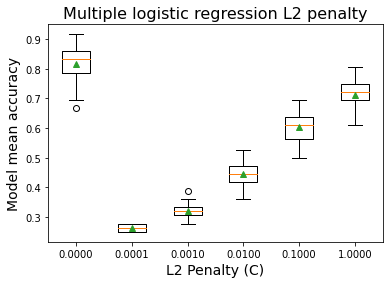

In [12]:
# train logistic classifier and predict on test samples

# data
#df_all_data_test
#all_labels_test
#df_training_data
#train_labels

def get_models():
	models = dict()
	for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
		# create name for model
		key = '%.4f' % p
		# turn off penalty in some cases
		if p == 0.0:
			# no penalty in this case
			models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none')
		else:
			models[key] = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=p)
	return models

def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

models = get_models()

results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the scores
	scores = evaluate_model(model, df_training_data_f, train_labels)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize progress along the way
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
ax = plt.boxplot(results, labels=names, showmeans=True)
plt.title("Multiple logistic regression L2 penalty", size=16)
plt.ylabel("Model mean accuracy", size=14)
plt.xlabel("L2 Penalty (C)", size=14)



In [200]:
Counter(all_labels_test)

Counter({'Lung_Cancer': 50,
         'Liver_Cancer': 32,
         'Prostate_Cancer': 11,
         'Ovarian_Cancer': 36,
         'Uterine_Cancer': 24,
         'Pancreatic_Cancer': 70,
         'Breast_Cancer': 28,
         'Esophageal_Cancer': 23,
         'CRC_stageIV': 24,
         'Healthy': 66})

In [201]:
Counter(train_labels)

Counter({'Lung_Cancer': 24,
         'Liver_Cancer': 26,
         'Prostate_Cancer': 29,
         'Ovarian_Cancer': 30,
         'Uterine_Cancer': 28,
         'Pancreatic_Cancer': 29,
         'Breast_Cancer': 23,
         'Esophageal_Cancer': 28,
         'CRC_stageIV': 48,
         'Healthy': 95})

10
172/389
percent accuracy: 0.44215938303341906


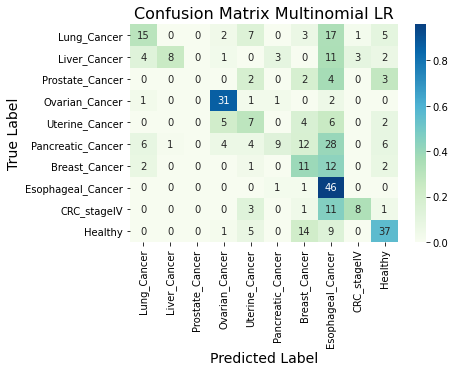

In [13]:
# for this model, cpg thresholds were chosen bases on tissue/plasma cross validation. Tissue and plasma data
# were subset to those thresholds, then a logistic model was trained on all tissues and testing/prediction
# was performed on all plasmas

def get_accuracy(df):
    total_incorrect = 0
    for i in df.index:
        for j in df.columns:
            if i!=j:
                total_incorrect += df.loc[i,j]
    total_samples = df_matches.sum().sum()
    print(f"{total_samples - total_incorrect}/{total_samples}")
    print(f"percent accuracy: {1 - total_incorrect/float(total_samples)}")

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none')
model.fit(df_training_data_ff, train_labels)

y_pred = model.predict(df_all_data_test_ff)

combos = list(zip(all_labels_test, y_pred))
#print(y_pred)
matches = []
for i in cancer_types + ["Healthy"]:
    matrix_row = []
    for j in cancer_types + ["Healthy"]:
        matrix_row.append(combos.count((i,j)))
    matches.append(matrix_row)
print(len(matches))
df_matches = pd.DataFrame(matches, columns=cancer_types + ["Healthy"],index=cancer_types + ["Healthy"])
accuracy = df_matches.div(df_matches.sum(axis=1),axis=0)
        
ax = sns.heatmap(accuracy, annot=df_matches, cmap="GnBu")
plt.title("Confusion Matrix Multinomial LR", size=16)
ax.set_xlabel("Predicted Label", size=14)
ax.set_ylabel("True Label", size=14)

get_accuracy(df_matches)

In [14]:
# remove Esophageal and rerun
keep_samples = [ct!="Esophageal_Cancer" for ct in train_labels]
df_training_data_noEsoph = df_training_data_ff[keep_samples]
train_labels_noEsoph = np.array(train_labels)[keep_samples]

keep_samples = [ct!="Esophageal_Cancer" for ct in all_labels_test]
df_all_data_test_noEsoph = df_all_data_test_ff[keep_samples]
all_labels_test_noEsoph = np.array(all_labels_test)[keep_samples]

9
144/341
percent accuracy: 0.42228739002932547


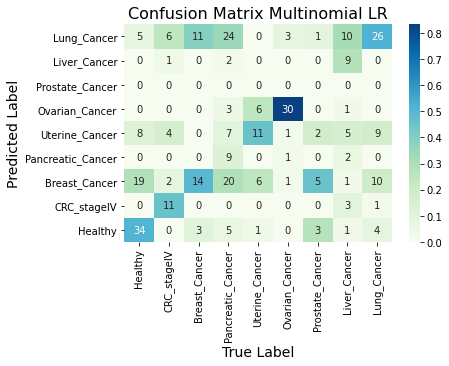

In [15]:
cancer_types_noEsoph = ["Lung_Cancer","Liver_Cancer",
                "Prostate_Cancer",
                "Ovarian_Cancer","Uterine_Cancer","Pancreatic_Cancer",
                "Breast_Cancer","CRC_stageIV","Healthy"
               ]

model.fit(df_training_data_noEsoph, train_labels_noEsoph)

y_pred = model.predict(df_all_data_test_noEsoph)

combos = list(zip(y_pred, all_labels_test_noEsoph))## NOTE switched this order for the plot
#print(y_pred)
matches = []
for i in cancer_types_noEsoph:
    matrix_row = []
    for j in cancer_types_noEsoph[::-1]:
        matrix_row.append(combos.count((i,j)))
    matches.append(matrix_row)
print(len(matches))
df_matches = pd.DataFrame(matches, columns=cancer_types_noEsoph[::-1],index=cancer_types_noEsoph)
accuracy = df_matches.div(df_matches.sum(axis=0),axis=1)
        
ax = sns.heatmap(accuracy, annot=df_matches, cmap="GnBu")
plt.title("Confusion Matrix Multinomial LR", size=16)
ax.set_ylabel("Predicted Label", size=14)
ax.set_xlabel("True Label", size=14)

get_accuracy(df_matches)

['Lung_Cancer', 'Liver_Cancer', 'Prostate_Cancer', 'Ovarian_Cancer', 'Uterine_Cancer', 'Pancreatic_Cancer', 'Breast_Cancer', 'CRC_stageIV', 'Healthy']
[0.52, 0.28125, 0.0, 0.8333333333333334, 0.4583333333333333, 0.12857142857142856, 0.5, 0.4583333333333333, 0.5151515151515151]


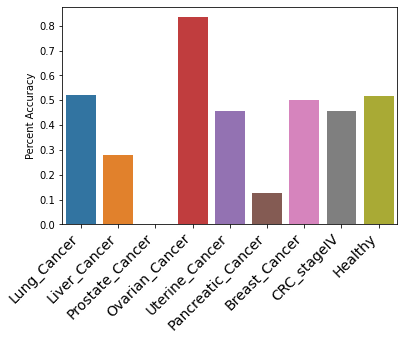

In [16]:
# Sensitivity plot of TOO calls
cancer_types_noEsoph = ["Lung_Cancer","Liver_Cancer",
                "Prostate_Cancer",
                "Ovarian_Cancer","Uterine_Cancer","Pancreatic_Cancer",
                "Breast_Cancer","CRC_stageIV","Healthy"
               ]
accuracies = []
for ct, row in df_matches.iterrows():
    acc = float(df_matches.loc[ct,ct]) / df_matches.loc[:,ct].sum()
    accuracies.append(acc)
    
ax = sns.barplot(x=cancer_types_noEsoph,y=accuracies)
ax.set_xticklabels(labels=cancer_types_noEsoph, size=14, ha="right",rotation=45)
ax.set_ylabel("Percent Accuracy")

print(cancer_types_noEsoph)
print(accuracies)

              score label   age     sex
               mean   max              
sample_id                              
13198      0.000000     0  68.0  Female
14067      0.442837     0  57.0  Female
14754      0.354780     0  77.0  Female
14879      0.693320     0  62.0  Female
19780      0.915825     0  65.0  Female
y      7.281243e-10
age    9.711301e-01
dtype: float64
              score label   age     sex
               mean   max              
sample_id                              
13198      0.463739     0  68.0  Female
14067      0.418309     0  57.0  Female
14754      0.283095     0  77.0  Female
14879      0.785082     0  62.0  Female
19780      0.623557     0  65.0  Female
y      0.000007
age    0.849634
dtype: float64
              score label   age     sex
               mean   max              
sample_id                              
13198      0.192713     0  68.0  Female
14067      0.160218     0  57.0  Female
14754      0.891623     0  77.0  Female
14879      0.62536

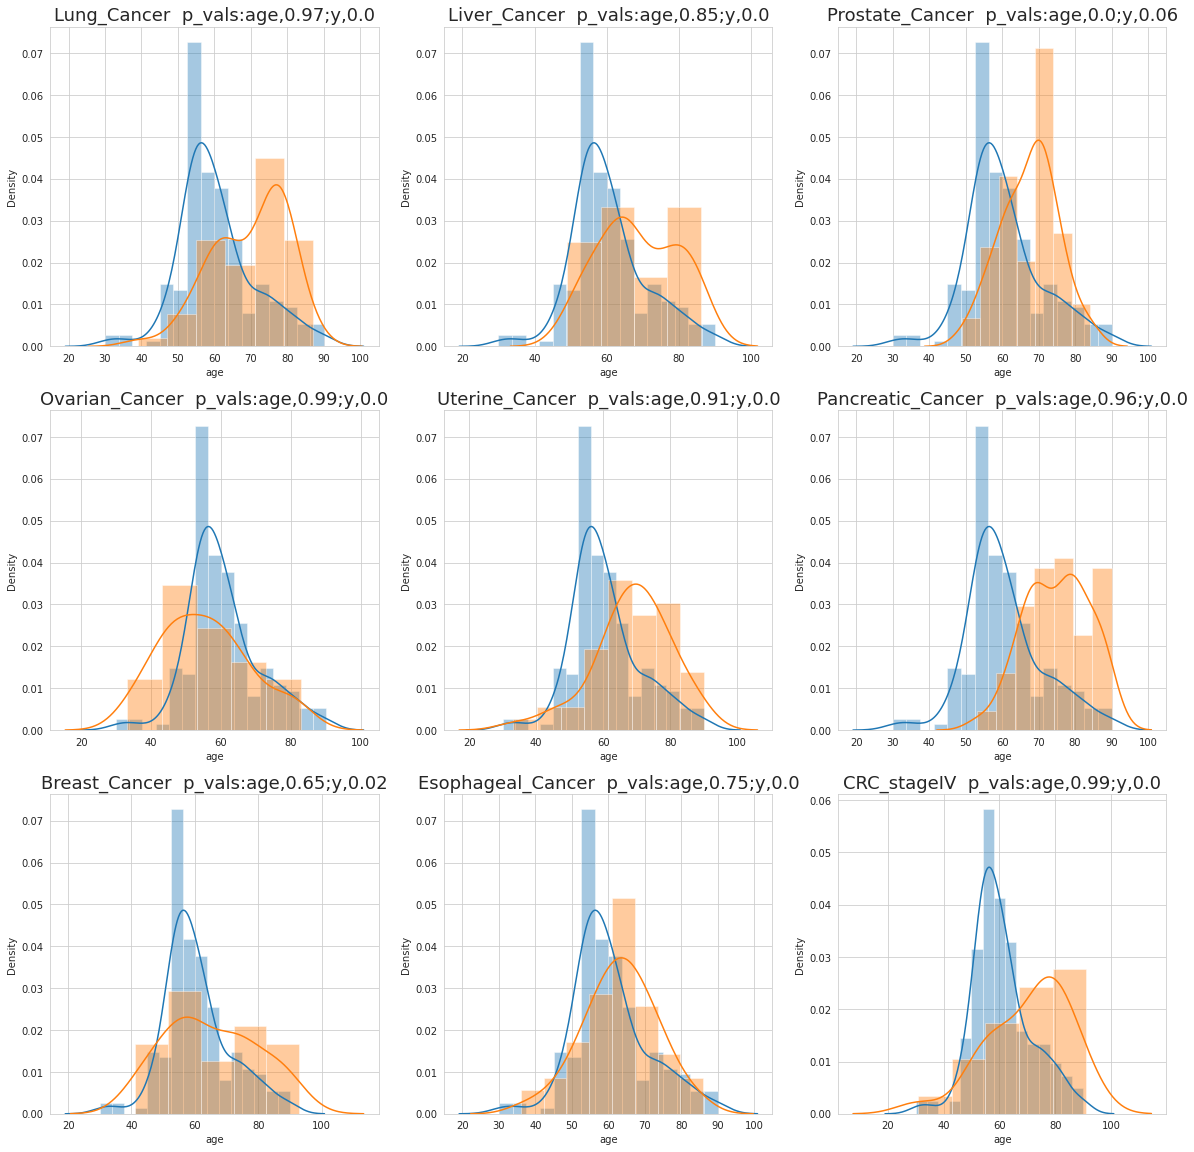

In [277]:
# Manual ANCOVA for age confounding by cancer type model
import statsmodels.api as sm

paths = [lung_path,liver_path, #prostate col meta missing for current feature
         prostate_path,
         ovarian_path,uterine_path,
         pancreatic_path,breast_path,esophageal_path,crc_path
        ]
cancer_types = ["Lung_Cancer","Liver_Cancer","Prostate_Cancer",
                "Ovarian_Cancer","Uterine_Cancer","Pancreatic_Cancer",
                "Breast_Cancer","Esophageal_Cancer","CRC_stageIV"
               ]
plt.subplots(nrows=3,ncols=3,figsize=(20,20))
for i,(path,cancer_type) in enumerate(zip(paths,cancer_types)):
    metrics, fold, table_score = load_results(bucket, path)
    table_score['score'] = table_score.score.apply(lambda x: x[1])
    #print(table_score["metadata"][0])
    
    ages = [m.raw_sample_metadata["lims_patient"]["age"] for m in table_score["metadata"]]
    sid_to_age = dict(zip(table_score["sample_id"].values, ages))
    missing = sum([a==None for sid,a in sid_to_age.items()])
    #print(f'{ages}')
    
    sexes = [m.raw_sample_metadata["lims_patient"]["sex"] for m in table_score["metadata"]]
    sid_to_sex = dict(zip(table_score["sample_id"].values, sexes))
    missing = sum([s==None for sid,s in sid_to_sex.items()])
    #print(f'{sexes}')
        
    df_table_score_means = table_score.groupby(["sample_id"]).agg({"score":["mean"],"label":["max"]})
    df_table_score_means["age"] = [sid_to_age[sid] for sid in df_table_score_means.index]
    df_table_score_means["sex"] = [sid_to_sex[sid] for sid in df_table_score_means.index]
    
    df = df_table_score_means.dropna(axis=0)
    print(df.head())
    df.columns = ["score","y","age","sex"]
    result = sm.OLS(df["score"], df.loc[:,["y","age"]]).fit()
    print(result.pvalues)
    
    plt.subplot(3,3,i+1)
    ax = sns.distplot(df[df['y']==0]["age"].values, label="healthy")
    ax2 = sns.distplot(df[df["y"]==1]["age"], label=cancer_type)
    ax.set_title(f"{cancer_type}  p_vals:age,{np.round(result.pvalues['age'],2)};y,{np.round(result.pvalues['y'],2)}", size=18)


